In [1]:
options(java.parameters = "-Xmx5g")

In [2]:
df <- read.csv("modified_dataset.csv")

In [3]:
library(BayesTree)

In [4]:
a <- gsub('\\+','',df$Installs)
a <- gsub(',','',a)
df$install_interval <- strtoi(a)


a <- gsub('\\M','',df$Size)
a <- gsub('Varies with device','',a)
df$Msize <- strtoi(a)


a <- gsub("\\$","",df$Price)
df$price <- as.numeric(a)

In [218]:
smp_size <- floor(0.70 * nrow(df))

train_ind <- sample(seq_len(nrow(df)), size = smp_size)

train <- df[train_ind, ]
test <- df[-train_ind, ]
y_test <- test$Rating
y_train <- train$Rating
#X_train <- train[c("neutralRate", "sentiment_polarity_mean", "sentiment_subjectivity_mean", "install_interval", "Reviews", "Msize", "price", "positive", "negative", "neutral")]
#X_test <- test[c("neutralRate", "sentiment_polarity_mean", "sentiment_subjectivity_mean", "install_interval", "Reviews", "Msize", "price", "positive", "negative", "neutral")]
X_train <- train[c( "negativeRate", "neutralRate", "sentiment_polarity_mean", "positiveRate")]
X_test <- test[c("negativeRate", "neutralRate", "sentiment_polarity_mean", "positiveRate")]
#X_train <- train[c("sentiment_polarity_mean", "install_interval", "Reviews")]
#X_test <- test[c("sentiment_polarity_mean", "install_interval", "Reviews")]

In [129]:
length(df$neutralRate)
length(df$neutral)

[1] 816

[1] 816

In [130]:
dim(X_train)
dim(X_test)

[1] 571   3

[1] 245   3

In [131]:
library(bartMachine)

In [210]:
b <- bart(x.train = X_train, y.train = y_train, x.test = X_test, ntree = 200)



Running BART with numeric y

number of trees: 200
Prior:
	k: 2.000000
	degrees of freedom in sigma prior: 3
	quantile in sigma prior: 0.900000
	power and base for tree prior: 2.000000 0.950000
	use quantiles for rule cut points: 0
data:
	number of training observations: 571
	number of test observations: 245
	number of explanatory variables: 5


Cutoff rules c in x<=c vs x>c
Number of cutoffs: (var: number of possible c):
(1: 100) (2: 100) (3: 100) (4: 100) (5: 100) 



Running mcmc loop:
iteration: 100 (of 1100)
iteration: 200 (of 1100)
iteration: 300 (of 1100)
iteration: 400 (of 1100)
iteration: 500 (of 1100)
iteration: 600 (of 1100)
iteration: 700 (of 1100)
iteration: 800 (of 1100)
iteration: 900 (of 1100)
iteration: 1000 (of 1100)
iteration: 1100 (of 1100)
time for loop: 18

Tree sizes, last iteration:
2 3 2 2 2 2 2 2 2 4 2 3 2 2 2 1 2 4 2 2 
2 3 4 2 3 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 
2 3 2 3 2 2 2 3 2 3 2 2 2 2 2 2 2 2 2 3 
2 2 3 2 2 2 2 3 2 2 3 3 2 3 2 2 3 3 2 4 
2 2 2 3 2 2 2 2 2

In [133]:
mean(b$yhat.test.mean)

[1] 4.294201

In [134]:
mean(y_test)

[1] 4.28449

In [135]:
SSE_200 <- sum((b$yhat.test.mean-y_test)^2)
SSE_200

[1] 19.75105

In [136]:
round(b$yhat.test.mean[1:10],1)
y_test[1:10]

[1] 4.4 4.3 4.4 4.4 4.2 4.2 4.1 4.2 4.4 4.2

[1] 4.5 4.7 4.9 4.6 4.3 4.0 4.4 4.2 4.5 4.3

In [137]:
get_accuracy <- function(y_hat, y_test, error){
    diff <- abs(y_hat - y_test)
    aux <- diff < (error*y_hat/100)
    acc <- sum(aux)/length(y_test)
    return (acc)
}

y_hat <- round(b$yhat.test.mean,1)
a <- get_accuracy(log(y_hat), log(y_test), 5)
a
0.661224489795918 # 5 variables
0.644897959183673 # 4 variables
0.604081632653061 # pos neg, sentiment polarity

[1] 0.8326531

[1] 0.6612245

[1] 0.644898

[1] 0.6040816

In [219]:
bart_object<- bartMachine(X_train, y_train, num_trees = 100, q = 0.90, nu = 3, use_missing_data = TRUE, k = 5)
#bart_object<- bartMachine(X_train, y_train)
#k: 5 nu, q: 3, 0.9 m: 200 

bartMachine initializing with 100 trees...
bartMachine vars checked...
bartMachine java init...
bartMachine factors created...
bartMachine before preprocess...
bartMachine after preprocess... 5 total features...
bartMachine sigsq estimated...
bartMachine training data finalized...
Now building bartMachine for regression ...Missing data feature ON. 
evaluating in sample data...done


In [220]:
bart_object

bartMachine v1.2.3 for regression

Missing data feature ON
training data n = 571 and p = 4 
built in 1.9 secs on 1 core, 100 trees, 250 burn-in and 1000 post. samples

sigsq est for y beforehand: 0.081 
avg sigsq estimate after burn-in: 0.07133 

in-sample statistics:
 L1 = 112.28 
 L2 = 38.61 
 rmse = 0.26 
 Pseudo-Rsq = 0.2505
p-val for shapiro-wilk test of normality of residuals: 0 
p-val for zero-mean noise: 0.82006 


.....


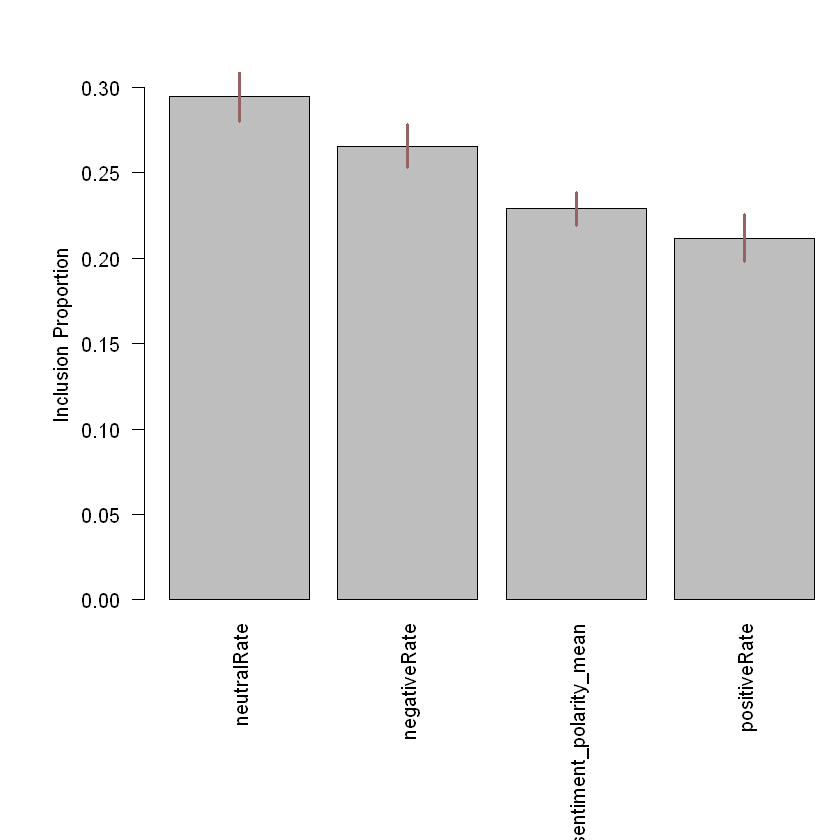

In [221]:
investigate_var_importance(bart_object)

In [ ]:
rmse_by_num_trees(bart_object, num_replicates = 20)

In [205]:
yhat <- predict(bart_object, X_test)

In [206]:
round(yhat[0:10],1)
y_test[0:10]

[1] 4.4 4.3 4.4 4.4 4.2 4.3 4.1 4.2 4.3 4.2

[1] 4.5 4.7 4.9 4.6 4.3 4.0 4.4 4.2 4.5 4.3

In [207]:
SSE_200 <- sum((y_hat-y_test)^2)
SSE_200

[1] 19.9

In [208]:
y_hat <- round(yhat,1)
a <- get_accuracy(log(y_hat), log(y_test), 5)
a
0.640816326530612 # 5 variables
0.63265306122449 # 4 vars
0.616326530612245 # 3 vars pos, neg, sent polarity

[1] 0.844898

[1] 0.6408163

[1] 0.6326531

[1] 0.6163265

In [143]:
bart_object2 <- bartMachineCV(X_train, y_train)

  bartMachine CV try: k: 2 nu, q: 3, 0.9 m: 50 
.....
  bartMachine CV try: k: 2 nu, q: 3, 0.9 m: 200 
.....
  bartMachine CV try: k: 2 nu, q: 3, 0.99 m: 50 
.....
  bartMachine CV try: k: 2 nu, q: 3, 0.99 m: 200 
.....
  bartMachine CV try: k: 2 nu, q: 10, 0.75 m: 50 
.....
  bartMachine CV try: k: 2 nu, q: 10, 0.75 m: 200 
.....
  bartMachine CV try: k: 3 nu, q: 3, 0.9 m: 50 
.....
  bartMachine CV try: k: 3 nu, q: 3, 0.9 m: 200 
.....
  bartMachine CV try: k: 3 nu, q: 3, 0.99 m: 50 
.....
  bartMachine CV try: k: 3 nu, q: 3, 0.99 m: 200 
.....
  bartMachine CV try: k: 3 nu, q: 10, 0.75 m: 50 
.....
  bartMachine CV try: k: 3 nu, q: 10, 0.75 m: 200 
.....
  bartMachine CV try: k: 5 nu, q: 3, 0.9 m: 50 
.....
  bartMachine CV try: k: 5 nu, q: 3, 0.9 m: 200 
.....
  bartMachine CV try: k: 5 nu, q: 3, 0.99 m: 50 
.....
  bartMachine CV try: k: 5 nu, q: 3, 0.99 m: 200 
.....
  bartMachine CV try: k: 5 nu, q: 10, 0.75 m: 50 
.....
  bartMachine CV try: k: 5 nu, q: 10, 0.75 m: 200 
.....
 

In [193]:
bart_object2

bartMachine v1.2.3 for regression

training data n = 571 and p = 3 
built in 6.4 secs on 1 core, 200 trees, 250 burn-in and 1000 post. samples

sigsq est for y beforehand: 0.088 
avg sigsq estimate after burn-in: 0.07906 

in-sample statistics:
 L1 = 118.41 
 L2 = 42.97 
 rmse = 0.27 
 Pseudo-Rsq = 0.2459
p-val for shapiro-wilk test of normality of residuals: 0 
p-val for zero-mean noise: 0.81284 


In [194]:
yhat <- predict(bart_object2, X_test)
round(yhat[0:10],1)
y_test[0:10]

[1] 4.4 4.3 4.4 4.4 4.1 4.3 4.1 4.2 4.3 4.2

[1] 4.5 4.7 4.9 4.6 4.3 4.0 4.4 4.2 4.5 4.3

In [195]:
y_hat <- round(yhat,1)
a <- get_accuracy(log(y_hat), log(y_test), 5)
a

[1] 0.8408163

In [114]:
0.820408163265306 # 3 variables

[1] 0.8204082

In [116]:
0.775510204081633 # 5 variables

[1] 0.7755102

In [153]:
0.771428571428571 # 4 variables

[1] 0.7714286

num_trees = ..5..5..5..5..5..5..5..5..5..5..5..5..5..5..5..5..5..5..5..5..10..10..10..10..10..10..10..10..10..10..10..10..10..10..10..10..10..10..10..10..20..20..20..20..20..20..20..20..20..20..20..20..20..20..20..20..20..20..20..20..30..30..30..30..30..30..30..30..30..30..30..30..30..30..30..30..30..30..30..30..40..40..40..40..40..40..40..40..40..40..40..40..40..40..40..40..40..40..40..40..50..50..50..50..50..50..50..50..50..50..50..50..50..50..50..50..50..50..50..50..100..100..100..100..100..100..100..100..100..100..100..100..100..100..100..100..100..100..100..100..150..150..150..150..150..150..150..150..150..150..150..150..150..150..150..150..150..150..150..150..200..200..200..200..200..200..200..200..200..200..200..200..200..200..200..200..200..200..200..200


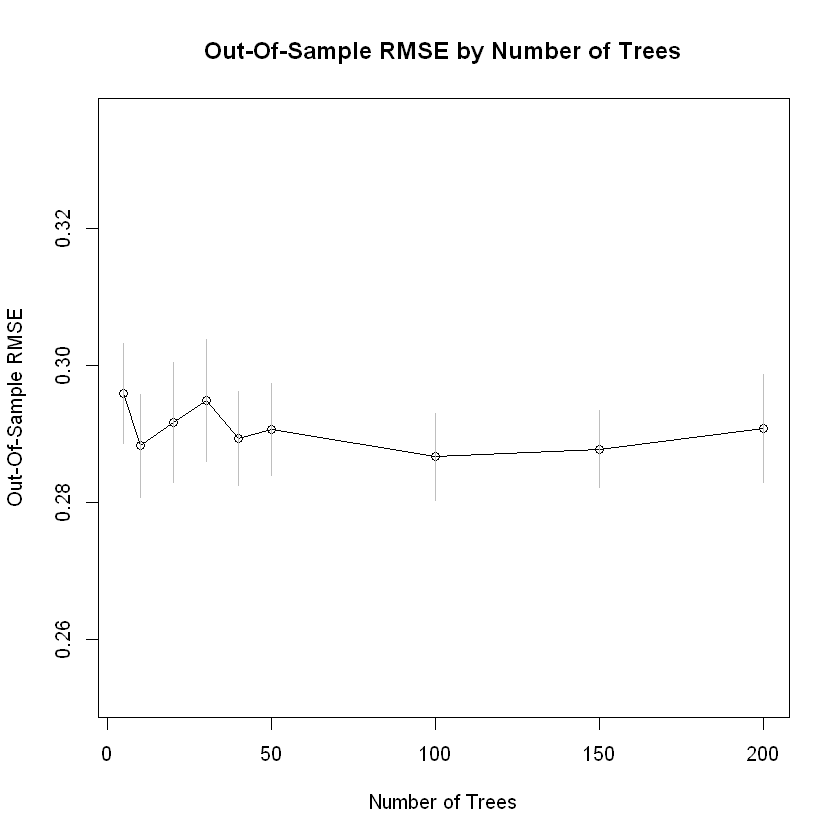

In [156]:
rmse_by_num_trees(bart_object2, num_replicates = 20)